In [152]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import tensorflow as tf
tf.__version__

'1.14.1'

In [2]:
import os
import matplotlib.pyplot as plt
import json
import math

In [257]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})


In [344]:
split = 'val'

In [208]:
split = 'train'

In [4]:
split = 'test'

In [414]:
output_dir = "eraserbenchmark/outputs/lambda_sweep/"
img_dir = 'graphics/'
color = {'macro-avg-F1': 'r', 'sufficiency': 'g', 'comprehensiveness': 'b', 'auprc':'black'}
linestyles = {'macro-avg-F1': '-', 'sufficiency': '--', "comprehensiveness": '-.', 'auprc':':'}

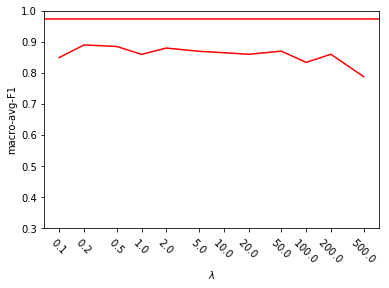

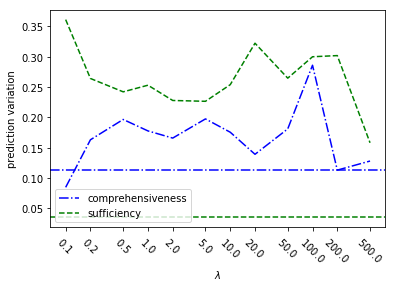

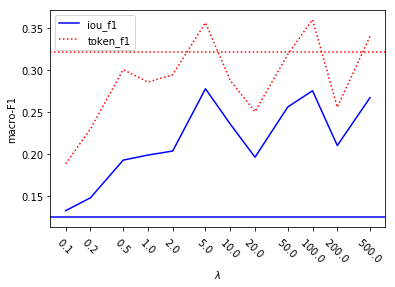

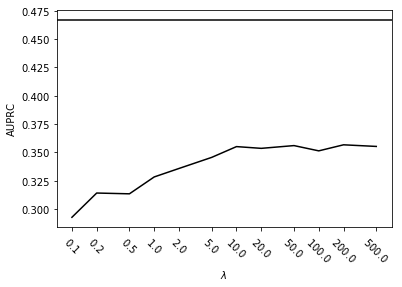

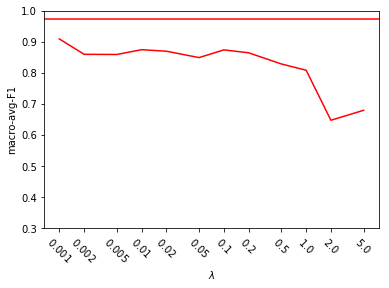

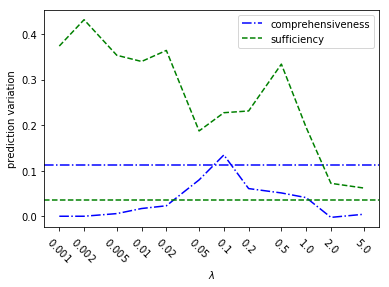

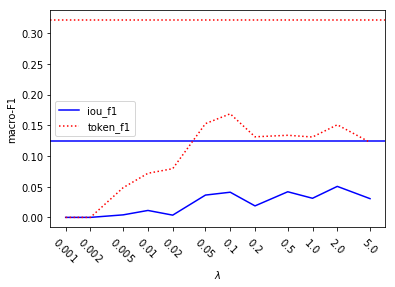

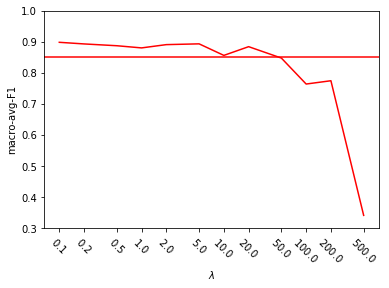

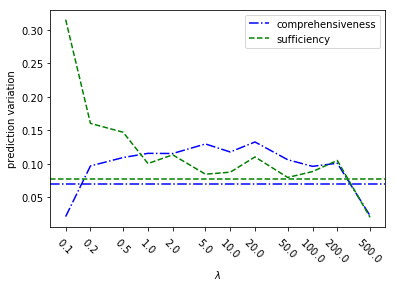

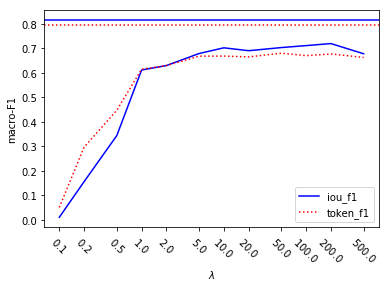

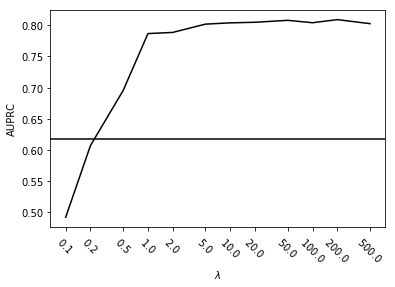

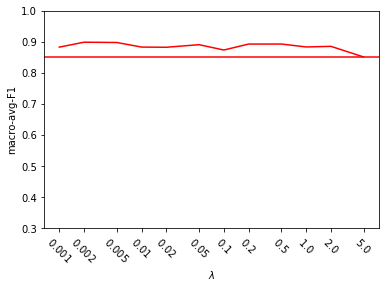

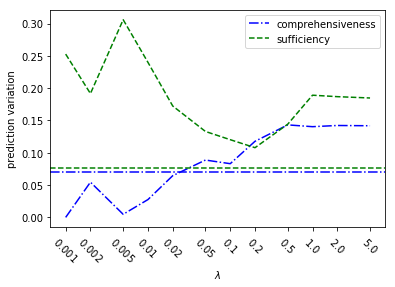

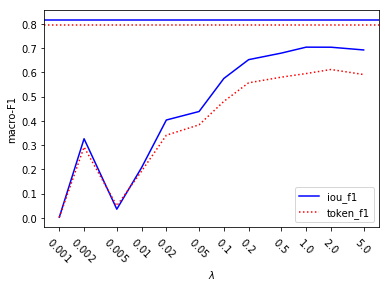

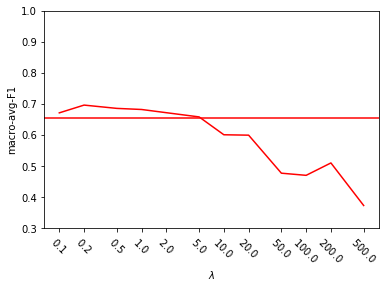

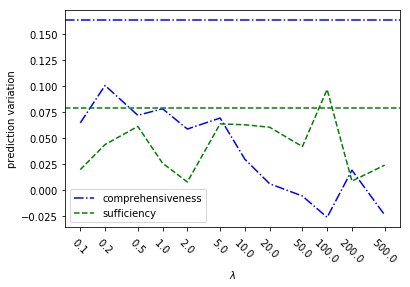

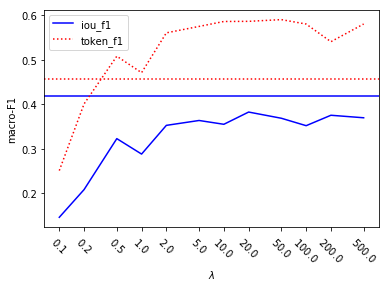

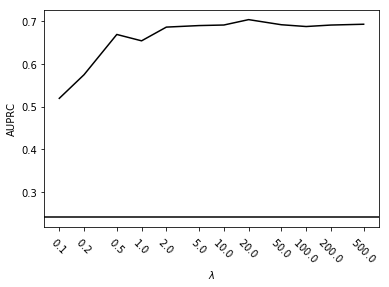

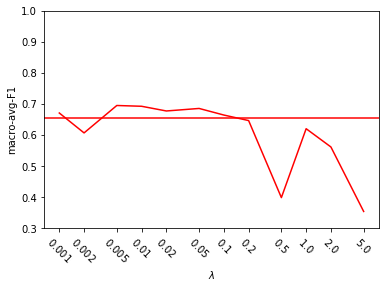

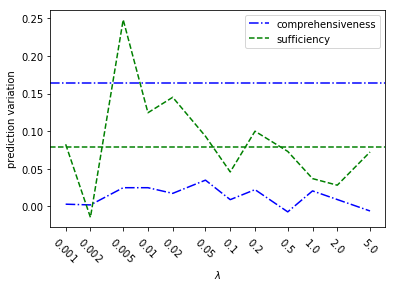

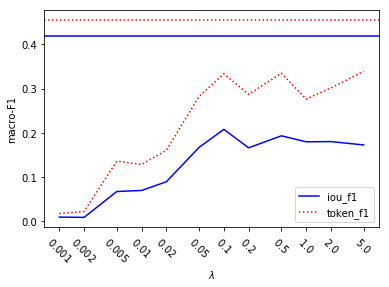

In [417]:
for dataset in ['movies', 'fever', 'multirc']:
    for structure in ['gru', 'rnr']:
        if structure == 'gru':
            par_lambdas = [0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 50., 100., 200., 500.]
        elif structure == 'rnr':
            par_lambdas = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1., 2., 5.]
        if dataset == 'movies':
            baseline = {'macro-avg-F1': 0.974, 'sufficiency':  0.035, 'comprehensiveness': 0.113,
                        'auprc':  0.467, "iou_f1": 0.124, 'token_f1': 0.322}
            train_on_portion = 0
        elif dataset == 'fever':
            baseline = {'macro-avg-F1': 0.850, 'sufficiency':  0.077, 'comprehensiveness': 0.070,
                        'auprc':  0.617, "iou_f1": 0.817, 'token_f1': 0.796}
            train_on_portion = 0.1
        elif dataset == 'multirc':
            baseline = {'macro-avg-F1': 0.655,
                    'sufficiency': 0.079,
                    'comprehensiveness': 0.164,
                    'auprc': 0.240,
                    'iou_f1': 0.419,
                    "token_f1": 0.456}
            train_on_portion = 0.4
        train_on_portion_str = str(train_on_portion).replace('.' , '_')
        results_dirs = [output_dir + f"bert_base_seqlen_512_{dataset}_exp_output_{structure}_merged_evidences{'_train_on_portion_'+str(train_on_portion) if train_on_portion != 0 else ''}_par_lambda_{par_lambda}_no_padding_imbalanced_bce_resampling_pooling_first_learning_rate_1e-05__{split}.txt" for par_lambda in par_lambdas]

        for results_dir in results_dirs:
            if not os.path.isfile(results_dir):
                print(results_dir)

        metrics = ['macro-avg-F1']
        results = []
        y = {metric:[] for metric in metrics}
        for results_dir in results_dirs:
            if os.path.isfile(results_dir):
                with open(results_dir, 'r') as fin:
                    r = eval(fin.read()[1:-1])
                results.append(r)
                for metric in metrics:
                    y[metric].append(r['classification_scores']['prf']['macro avg']['f1-score'])
            else:
                for metric in metrics:
                    y[metric].append(0)
        fig, ax = plt.subplots()
        plt.xlabel("$\lambda$")
        plt.ylabel("macro-avg-F1")
        plt.xticks([math.log(i) for i in par_lambdas], [("$"+str(l)+"$") for l in par_lambdas], rotation=-45)
        for metric in metrics:
            plt.axhline(y=baseline[metric], color=color[metric], linestyle=linestyles[metric])
            ax.plot([math.log(i) for i in par_lambdas], y[metric], label=metric, color=color[metric], linestyle=linestyles[metric])
        plt.ylim([0.3, 1])
        #ax.legend()
        plt.savefig(img_dir + f'{dataset}_{structure}_{split}_train_on_portion_{train_on_portion_str}_macro_avg_f1.png', dpi=300)
        
        metrics = ["comprehensiveness", 'sufficiency']
        results = []
        y = {metric:[] for metric in metrics}
        for results_dir in results_dirs:
            if os.path.isfile(results_dir):
                with open(results_dir, 'r') as fin:
                    r = eval(fin.read()[1:-1])
                results.append(r)
                for metric in metrics:
                    y[metric].append(r['classification_scores'][metric])
            else:
                for metric in metrics:
                    y[metric].append(0)

        fig, ax = plt.subplots()
        plt.xlabel("$\lambda$")
        plt.xticks([math.log(i) for i in par_lambdas], [("$"+str(l)+"$") for l in par_lambdas], rotation=-45)
        plt.ylabel("prediction variation")

        for metric in metrics:
            plt.axhline(y=baseline[metric], color=color[metric], linestyle=linestyles[metric])
            ax.plot([math.log(i) for i in par_lambdas], y[metric], label=metric, color=color[metric], linestyle=linestyles[metric])
        ax.legend()
        plt.savefig(img_dir + f'{dataset}_{structure}_{split}_train_on_portion_{train_on_portion_str}_cs.png', dpi=300)

        fig, ax = plt.subplots()
        plt.axhline(y=baseline['iou_f1'], color='b', linestyle='-')
        ax.plot([math.log(i) for i in par_lambdas], [results[i]['iou_scores'][0]['macro']['f1']
                                                     for i in range(len(par_lambdas))], label='iou_f1', color='b')
        plt.axhline(y=baseline['token_f1'], color='r', linestyle=':')
        ax.plot([math.log(i) for i in par_lambdas], [results[i]['token_prf']['instance_micro']['f1']
                                                     for i in range(len(par_lambdas))], label='token_f1', color='r', linestyle=':')
        plt.xlabel("$\lambda$")
        plt.ylabel("macro-F1")
        plt.xticks([math.log(i) for i in par_lambdas], [("$"+str(l)+"$") for l in par_lambdas], rotation=-45)
        ax.legend()
        plt.savefig(img_dir + f'{dataset}_{structure}_{split}_train_on_portion_{train_on_portion_str}_iou_token_f1.png', dpi=300)

        if structure == 'gru':
            metrics = ['auprc']
            rs = []
            y = {metric:[] for metric in metrics}
            for results_dir in results_dirs:
                if os.path.isfile(results_dir):
                    with open(results_dir, 'r') as fin:
                        r = fin.read()
                        r = eval(r[1:-1])
                    rs.append(r)
                    for metric in metrics:
                        y[metric].append(r['token_soft_metrics'][metric])
                else:
                    for metric in metrics:
                        y[metric].append(0)

            fig, ax = plt.subplots()
            plt.xlabel("$\lambda$")
            plt.ylabel("AUPRC")
            plt.xticks([math.log(i) for i in par_lambdas], [("$"+str(l)+"$") for l in par_lambdas], rotation=-45)
            for metric in metrics:
                plt.axhline(y=baseline[metric], color=color[metric], linestyle='-')
                ax.plot([math.log(i) for i in par_lambdas], y[metric], label='AUPRC', color=color[metric])
            #plt.ylim([0.5, 1])
            #ax.legend()
            plt.savefig(img_dir + f'{dataset}_{structure}_{split}_train_on_portion_{train_on_portion_str}_auprc.png', dpi=300)

In [208]:
list(zip(par_lambdas, [math.log(i) for i in par_lambdas]))

[(0.001, -6.907755278982137),
 (0.002, -6.214608098422191),
 (0.005, -5.298317366548036),
 (0.01, -4.605170185988091),
 (0.02, -3.912023005428146),
 (0.05, -2.995732273553991),
 (0.1, -2.3025850929940455),
 (0.2, -1.6094379124341003),
 (0.5, -0.6931471805599453),
 (1.0, 0.0),
 (2.0, 0.6931471805599453),
 (5.0, 1.6094379124341003)]